# Retrieving active cases in Shanghai & China excl.Hubei

The purpose of this notebook is to draw an evolution of **active** cases
(i.e. *confirmed* - *cured* - *dead*) **relative** to a given reference date in 2 locations:
* China excluding Hubei
* Shanghai


## 1. Getting Data

### 1a. Data extraction and cleaning
We first retrieve the data from a github repository with data on China & other countries.

We have to perform some cleaning
* Extracting data related to China
* Only keeping data for country and provinces (i.e. "city" information is *null*)
* Dropping useless columns

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

REF_DATE = "2020-01-26"

In [2]:
url = "https://github.com/canghailan/Wuhan-2019-nCoV/raw/master/Wuhan-2019-nCoV.csv"
whole_df = pd.read_csv(url)

In [3]:
# stats for China country as "province" set to "na"
china = whole_df[whole_df["countryCode"]=="CN"].fillna({"province":"China"})
df = china[china["city"].isnull()]
df.drop(["country", "countryCode", "cityCode", "provinceCode", "city"], axis="columns", inplace=True)
df

c:\python37-32\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,province,confirmed,suspected,cured,dead
0,2019-12-01,China,1,0,0,0
1,2019-12-01,湖北省,1,0,0,0
3,2019-12-02,China,1,0,0,0
4,2019-12-02,湖北省,1,0,0,0
6,2019-12-03,China,1,0,0,0
...,...,...,...,...,...,...
47409,2020-04-11,宁夏回族自治区,75,0,75,0
47417,2020-04-11,新疆维吾尔自治区,76,0,73,3
47446,2020-04-11,台湾省,385,0,99,6
47448,2020-04-11,香港特别行政区,1000,0,336,4


### 1b. Data selection

We can then keep data for:
* China
* Hubei
* Shanghai

We can then add the number of active cases

In [4]:
selection = df[(df.province == "China") | (df.province == "湖北省") | (df.province == "上海市")]
selection = selection.replace("湖北省", "Hubei").replace("上海市", "Shanghai")
selection["active"] = selection["confirmed"] - selection["cured"] - selection["dead"]
# selection.to_csv("China_Hubei_Shanghai.csv")
selection

,date,province,confirmed,suspected,cured,dead,active
0,2019-12-01,China,1,0,0,0,1
1,2019-12-01,Hubei,1,0,0,0,1
3,2019-12-02,China,1,0,0,0,1
4,2019-12-02,Hubei,1,0,0,0,1
6,2019-12-03,China,1,0,0,0,1
...,...,...,...,...,...,...,...
46289,2020-04-10,Shanghai,555,0,435,7,113
46420,2020-04-10,Hubei,67803,0,64264,3219,320
46913,2020-04-11,China,83400,44,77980,3349,2071
47036,2020-04-11,Shanghai,555,0,438,7,110


### 1c. Data computation

We can then group by provinces and compute nb of active cases relative to a given date.

We need to:
1. Group data  by provinces
2. Compute data for "China excl. Hubei"
3. Remove data for "China" and "Hubei"
4. Extract the values for reference date (e.g. 2020-01-26)
5. Divide dataframe by these reference values to get relative values

In [5]:
to_plot = selection.pivot(index="date", columns="province", values="active").fillna(0)
to_plot["China excl. Hubei"] = to_plot["China"] - to_plot["Hubei"]
to_plot.drop(["China", "Hubei"], axis="columns", inplace=True)

to_plot = to_plot / to_plot.loc[REF_DATE]
to_plot.loc[REF_DATE:]

province,Shanghai,China excl. Hubei
date,,
2020-01-26,1.000000,1.000000
2020-01-27,1.215686,1.360305
2020-01-28,1.470588,1.824427
2020-01-29,1.862745,2.353435
2020-01-30,2.392157,2.917557
...,...,...
2020-04-07,2.549020,1.359542
2020-04-08,2.509804,1.368702
2020-04-09,2.470588,1.351908


## 2. Drawing a plot

We can finally draw a plot of relative active cases along time.

We will trim data before the reference date (where values would be too small) so we should start at 100%.

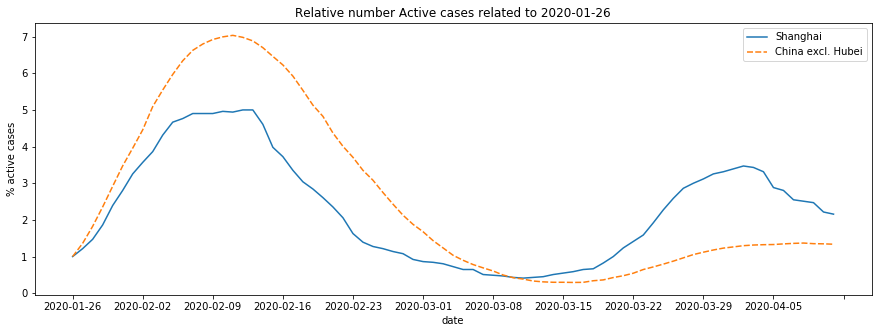

In [8]:
loc = plticker.MultipleLocator(base=7.0) # We want to put a tick every seven days 

plt.figure(figsize=(15, 5))
plt.title(f"Relative number Active cases related to {REF_DATE}")
plt.ylabel("% active cases")
axes = sns.lineplot(data=to_plot.loc[REF_DATE:])
axes.xaxis.set_major_locator(loc)